# Build Model and Analyze System
The purpose of this notebook is to analyze the .csv files (results, data) created from predictsystem.ipynb, and generate candidates for full long Nbody simulations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import rebound
import pandas as pd
from xgboost.sklearn import XGBClassifier 
from sklearn.metrics import roc_auc_score
import pickle
from generatefeatures import generate_features
import time
import os
%matplotlib inline

/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [22]:
system='KOI-1576'
orb_params = ["m1","T1","P1","h1","k1","m2","T2","P2",
                              "h2","k2","m3","T3","P3","h3","k3"]
data = pd.read_csv("systems/data_files/jontoff-hutter/%s.dat"%system, names=orb_params, sep="\s+")

In [24]:
np.mean(data.m3 * 0.907), np.std(data.m3 * 0.907)

(0.84327472964200001, 1.2824630234120977)

In [15]:
#Stellar masses for all possible systems of interest
Ms = {}
Ms["KOI-0156"] = 0.56; Ms["KOI-0168"] = 1.11; Ms["KOI-2086"] = 1.04; Ms["Kepler-431"] = 1.071;
Ms["KOI-0085"] = 1.25; Ms["KOI-0115"] = 0.961; Ms["KOI-0152"] = 1.165; Ms["KOI-0250"] = 0.544;
Ms["KOI-0314"] = 0.521; Ms["KOI-0523"] = 1.07; Ms["KOI-0738"] = 0.979; Ms["KOI-1270"] = 0.83;
Ms["KOI-1576"] = 0.907; Ms["LP-358-499"] = 0.52; Ms["Kepler-446"] = 0.22
epoch = 780

## Load data and Nbody results

In [2]:
#Dont think I need this cell anymore really...

#Systems: KOI-0085, KOI-0115, KOI-152, KOI-0156, KOI-0168, KOI-250, KOI-314, KOI-1576, KOI-2086, Kepler-431
system = "KOI-0115"  

#load data and predicted stability probabilities
data = pd.read_csv("systems/%s_data.csv"%system)

#load Nbody results
columns = ["name","id","shadow","maxorbs","P1","time","dE","elapsed_time"]
Nbody = pd.read_csv("systems/%s_Nbodyresults.csv"%system,names=columns)

## Load Model and Generate Predictions

In [16]:
#####################################################
def build_model(model_SIfeatures, model_path, features, augmented_systems):
    try:
        model = pickle.load(open("%s.pkl"%model_path, 'rb'))
        print("Successfully Loaded Model %s"%model_path)
    except:
        print("Couldn't Load model, building from scratch.")
        df = pd.read_csv(model_SIfeatures, index_col=0)
        del df['instability_time']
        del df['Rel_Eerr']
        del df['Rel_Eerr_short']
        del df["runstring"]
        
        #get train/test data
        y = df['Stable']
        X = df[features]
        Nrows = int(X.shape[0] * 0.8)

        trainX = X.iloc[:Nrows,:]
        trainY = y.iloc[:Nrows]
        testX = X.iloc[Nrows:, :]
        testY = y.iloc[Nrows:]
        
        #Augment Training X and Y with additional datasets
        Nbody_columns = ["name","id","shadow","maxorbs","P1","time","dE","elapsed_time"]
        if len(augmented_systems) > 0:
            print "Augmenting training set with:"
        for sys in augmented_systems:
            print sys
            SI = pd.read_csv("systems/%s_preds.csv"%sys, index_col=0)[features]
            Nbody = pd.read_csv("systems/%s_Nbodyresults.csv"%system,names=Nbody_columns)

            stablemask = (Nbody.shadow == 0)&(Nbody.time >= Nbody.P1*Nbody.maxorbs-1) #-1 for near-exact quantities
            unstablemask = (Nbody.shadow == 0)&(Nbody.time < Nbody.P1*Nbody.maxorbs)
            stable = SI.loc[Nbody[stablemask].id.values, features]
            unstable = SI.loc[Nbody[unstablemask].id.values, features]
            y_aug = pd.Series(np.concatenate((np.ones(len(stable)),np.zeros(len(unstable)))))
            
            trainX = pd.concat([trainX,stable,unstable])
            trainY = pd.concat([trainY,y_aug])

        #Dan's best model parameters from Analysis/Old_Tuning_Notebooks/ApplicationsModel.ipynb
        best = {'x_learning_rate': 0.00158945659624887,
                'x_max_depth': 10,'x_min_child': 5,
                'x_subsample': 0.8842843039075888,
                'x_tree_colsample': 0.5393796629807249}

        model = XGBClassifier(seed = 0, min_child_weight=best["x_min_child"],
                                  max_depth = best["x_max_depth"],
                                  subsample = best["x_subsample"],
                                  colsample_bytree = best["x_tree_colsample"],
                                  learning_rate = best["x_learning_rate"])
        model.fit(trainX, trainY)
        pickle.dump(model,open("%s.pkl"%model_path, 'wb'))
        preds = model.predict_proba(testX)[:,1]
        auc_Score = roc_auc_score(testY,preds)
        print("AUC Score=%f"%auc_Score)
        print("Successfully built model %s"%model_path)
    return model

#####################################################
def get_predictions(data,model,Ms,epoch,features,path_to_preds,model_basename):
    try:
        preds = pd.read_csv(path_to_preds,index_col=0)
        print("Successfully Loaded Previously Generated Features and Predictions.")
    except:    
        print("Couldn't load preds, generating SI features and preds.")
        start = time.time()
        fullfeatures = []
        for index, d in data.iterrows():
            fullfeatures.append(generate_features(d, Ms, epoch))

        # compile results - take only the features the model uses
        preds = pd.DataFrame(columns=features)
        for i in range(len(fullfeatures)):
            preds.loc[i] = fullfeatures[i][features] 
        print "%d simulations took %f seconds"%(len(data), time.time() - start)
            
    # predict stability 
    preds["%s_predict_proba"%model_basename] = model.predict_proba(preds[features])[:,1]
    
    #save model
    preds.to_csv(path_to_preds)
    print("Successfully generated new predictions for model %s.pkl."%model_basename)
    
    return preds

In [17]:
#model features
features = []
features += ['avg_iH1', 'avg_iH2']
features += ['norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1']
features += ['norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2']
features += ['norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3']
features += ['avg_ecross1', 'std_ecross1', 'max_ecross1', 'min_ecross1']
features += ['avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2']
features += ['avg_ecross3', 'std_ecross3', 'max_ecross3', 'min_ecross3']

Load Model if available, or build from scratch if short integration features are provided.

In [18]:
#Load/Build model
model_SIfeatures_csv = "models/csv/short_integration_features.csv"
model_path_name = "models/ApplicationsModel"
#model_path_name = "models/ApplicationsModel_augmented2"    #.pkl is the extension automatically added
#augmented_systems = ["KOI-0115","KOI-0152","KOI-1576","KOI-2086"]
#augmented_systems2 = ["KOI-0152","KOI-0168","KOI-0250","KOI-0314"]
augmented_systems = []

model = build_model(model_SIfeatures_csv, model_path_name, features, augmented_systems)

Successfully Loaded Model models/ApplicationsModel


Generate Predictions - example - Single system

In [19]:
#Systems:KOI-0085, KOI-0115, KOI-152, KOI-0156, KOI-0168, KOI-250, KOI-314, KOI-1576, KOI-2086, Kepler-431, LP-358-499
#system = "LP-358-499"  
system = "Kepler-446"
data = pd.read_csv("systems/%s_data.csv"%system)

path_to_preds = "systems/%s_preds.csv"%system
proba = get_predictions(data,model,Ms[system],epoch,features,path_to_preds,os.path.basename(model_path_name))

Successfully Loaded Previously Generated Features and Predictions.
Successfully generated new predictions for model ApplicationsModel.pkl.


Generate Predictions - batch

In [82]:
systems = ["KOI-0085", "KOI-0115", "KOI-0152", "KOI-0156", "KOI-0168", 
           "KOI-0250", "KOI-0314", "KOI-1576", "KOI-2086", "Kepler-431"]

for s in systems:
    data = pd.read_csv("systems/%s_data.csv"%s)
    path_to_preds = "systems/%s_preds.csv"%s
    proba = get_predictions(data,model,Ms[s],epoch,features,path_to_preds,os.path.basename(model_path_name))
    print "Completed System %s"%s

Successfully Loaded Previously Generated Features and Predictions.
Successfully generated new predictions for model ApplicationsModel_augmented2.pkl.
Completed System KOI-0085
Successfully Loaded Previously Generated Features and Predictions.
Successfully generated new predictions for model ApplicationsModel_augmented2.pkl.
Completed System KOI-0115
Successfully Loaded Previously Generated Features and Predictions.
Successfully generated new predictions for model ApplicationsModel_augmented2.pkl.
Completed System KOI-0152
Successfully Loaded Previously Generated Features and Predictions.
Successfully generated new predictions for model ApplicationsModel_augmented2.pkl.
Completed System KOI-0156
Successfully Loaded Previously Generated Features and Predictions.
Successfully generated new predictions for model ApplicationsModel_augmented2.pkl.
Completed System KOI-0168
Successfully Loaded Previously Generated Features and Predictions.
Successfully generated new predictions for model Appl

## Plot Stability Predictions and Results

can't find h and k entries, calculating.


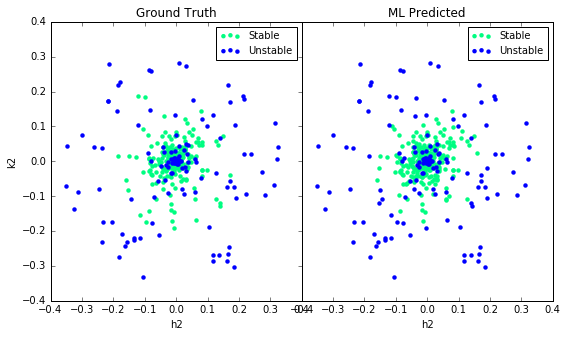

In [20]:
import matplotlib
#Systems:KOI-0085,KOI-0115,KOI-0152,KOI-0156,KOI-0168,KOI-0250,KOI-0314,KOI-1576,KOI-2086,Kepler-431,LP-358-499
#system = "LP-358-499"  
#system = "Kepler-431"
system = "Kepler-446"

#plotting variables
x = "h2"
y = "k2"
shadow = 0   #0 or 1
prob_thresh = 0.5

#data
columns = ["name","id","shadow","maxorbs","P1","time","dE","elapsed_time"]
Nbody = pd.read_csv("systems/%s_Nbodyresults.csv"%system,names=columns)
preds = pd.read_csv("systems/%s_preds.csv"%system,index_col=0)
data = pd.read_csv("systems/%s_data.csv"%system,index_col=0)
try:
    data["e1"] = np.sqrt(data["h1"]**2 + data["k1"]**2)
    data["e2"] = np.sqrt(data["h2"]**2 + data["k2"]**2)
    data["e3"] = np.sqrt(data["h3"]**2 + data["k3"]**2)
except:
    print "can't find h and k entries, calculating."
    data["h1"], data["k1"] = data["e1"]*np.sin(data["w1"]), data["e1"]*np.cos(data["w1"])
    data["h2"], data["k2"] = data["e2"]*np.sin(data["w2"]), data["e2"]*np.cos(data["w2"])
    data["h3"], data["k3"] = data["e3"]*np.sin(data["w3"]), data["e3"]*np.cos(data["w3"])

#stable/unstable masks
stablemask = (Nbody.shadow == shadow)&(Nbody.time >= Nbody.P1*Nbody.maxorbs-1) #-1 for near-exact quantities
unstablemask = (Nbody.shadow == shadow)&(Nbody.time < Nbody.P1*Nbody.maxorbs)
pstablemask = preds["%s_predict_proba"%os.path.basename(model_path_name)] >= prob_thresh
punstablemask = preds["%s_predict_proba"%os.path.basename(model_path_name)] < prob_thresh

#plot
colorbar = 'winter'
cmap = matplotlib.cm.get_cmap(colorbar)
f, (ax1, ax2) = plt.subplots(1,2, figsize=[9, 5], sharex=True, sharey=True)
ax1.scatter(data.loc[Nbody[stablemask].id.values, x],data.loc[Nbody[stablemask].id.values, y], c=cmap(0.99), lw=0, label='Stable')
ax1.scatter(data.loc[Nbody[unstablemask].id.values, x],data.loc[Nbody[unstablemask].id.values, y], c=cmap(0.), lw=0, label='Unstable')
ax2.scatter(data.loc[pstablemask, x],data.loc[pstablemask, y], c=cmap(0.99), lw=0, label='Stable')
ax2.scatter(data.loc[punstablemask, x],data.loc[punstablemask, y], c=cmap(0.), lw=0, label='Unstable')

#prettify
ax1.set_title("Ground Truth")
ax1.set_xlabel(x)
ax1.set_ylabel(y)
ax1.legend(numpoints=1, fontsize=10)
ax2.set_title("ML Predicted")
ax2.set_xlabel(x)
ax2.legend(numpoints=1, fontsize=10)
ax2.tick_params(axis='y', which='both', left='off', right='off')
plt.subplots_adjust(wspace=0)
plt.savefig('images/%s_%s_vs_%s.png'%(system,x,y))

## Precision-Recall

In [8]:
N = len(Nbody[stablemask]) + len(Nbody[unstablemask])
y_true = np.zeros(N)
y_true[0:len(Nbody[stablemask])] = 1

y_pred = []
for id_ in np.concatenate((Nbody[stablemask].id.values,Nbody[unstablemask].id.values)):
    y_pred.append((preds["%s_predict_proba"%os.path.basename(model_path_name)].iloc[id_] >= prob_thresh)*1)
y_pred = np.asarray(y_pred)

true_positive = np.where((y_pred == 1)&(y_true==1))[0]
false_positive = np.where((y_pred == 1)&(y_true==0))[0]
false_negative = np.where((y_pred == 0)&(y_true==1))[0]

precision = len(true_positive)*1./(len(true_positive) + len(false_positive))
recall = len(true_positive)*1./(len(true_positive) + len(false_negative))
print "%s: The precision is %f and recall is %f"%(system, precision, recall)

Kepler-446: The precision is 0.986864 and recall is 0.974068


In [13]:
len(Nbody[unstablemask])/float(len(Nbody[stablemask]))

0.29497568881685576